# Extracting postcodes from ONSPDF

1. Manually Download .zip for ONS Postcode Directory. 
    
    May 2023 version can be downloaded here: https://geoportal.statistics.gov.uk/datasets/a2f8c9c5778a452bbf640d98c166657c/about

2. Manually Unzip the files

3. Use this notebook to process into a DataFrame

In [1]:
import os
import pandas as pd

## Get a Pandas DataFrame

In [2]:
COLUMN_MAP = {
    "pcd": "postcode",
    "dointr": "date_of_introduction",
    "doterm": "date_of_termination",
    "ctry": "country",
    "lat": "latitude",
    "long": "longitude"
}

COUNTRY_MAP = {
    "E92000001": "England",
    "W92000004": "Wales",
    "S92000003": "Scotland",
    "N92000002": "Northern Ireland",
    "L93000001": "Channel Islands",
    "M83000003": "Isle of Man"
}    

def list_csv(directory):
    return [f"{directory}/{f}" for f in os.listdir(directory) if f.endswith('.csv')]

def normaize_passcode(postcode: str) -> str:
    postcode = postcode.replace(" ", "")
    return f"{postcode[:-3]} {postcode[-3:]}"

def get_outcode(postcode: str) -> str:
    return postcode.split(" ")[0]

def extract_postcode_data(data: pd.DataFrame) -> pd.DataFrame:
    postcodes = data.rename(columns=COLUMN_MAP)
    postcodes = postcodes[COLUMN_MAP.values()]
    postcodes["active"] = postcodes["date_of_termination"].isna()
    postcodes["country"] = postcodes["country"].apply(lambda code: COUNTRY_MAP[code])
    postcodes["postcode"] = postcodes["postcode"].apply(normaize_passcode)
    postcodes["outcode"] = postcodes["postcode"].apply(get_outcode)
    return postcodes

def summarize_postcode_data(df: pd.DataFrame) -> pd.DataFrame:
    # Num active and num terminated
    active = df["active"].value_counts()
    print(f"Total postcodes: {df.shape[0]:,}")
    print(f"Active: {active[True]:,}")
    print(f"Terminated: {active[False]:,}")
    # Oldest and newest
    oldest = df["date_of_introduction"].min()
    newest = df["date_of_termination"].max()
    print(f"Oldest: {oldest}")
    print(f"Newest: {newest}")
    # Num unique outcodes
    unique_outcodes = df["outcode"].nunique()
    print(f"Unique outcodes: {unique_outcodes:,}")

def combine_multi_csv(multi_csv_path: str, summarize=True) -> pd.DataFrame:
    files = list_csv(multi_csv_path)
    df_list = []
    for csv in files:
        data = pd.read_csv(csv, usecols=COLUMN_MAP.keys())
        df_list.append(extract_postcode_data(data))
    combined = pd.concat(df_list, axis=0) 
    combined["date_of_introduction"] = pd.to_datetime(combined["date_of_introduction"], format="%Y%m")
    combined["date_of_termination"] = pd.to_datetime(combined["date_of_termination"], format="%Y%m")
    if summarize:
        summarize_postcode_data(combined)
    return combined.reset_index(drop=True)

In [3]:
# commented out as newer version is available
# onspd_data_nov_2022 = combine_multi_csv("ONSPD_NOV_2022_UK/Data/multi_csv/")

Total postcodes: 2,683,734
Active: 1,791,293
Terminated: 892,441
Oldest: 1973-08-01 00:00:00
Newest: 2022-10-01 00:00:00
Unique outcodes: 3,118


In [4]:
onspd_data_may_2023 = combine_multi_csv("ONSPD_MAY_2023_UK/Data/multi_csv/")

Total postcodes: 2,690,850
Active: 1,794,831
Terminated: 896,019
Oldest: 1973-08-01 00:00:00
Newest: 2023-04-01 00:00:00
Unique outcodes: 3,118


In [5]:
onspd_data_may_2023

,postcode,date_of_introduction,date_of_termination,country,latitude,longitude,active,outcode
0,IV1 1AA,1980-01-01,2022-09-01,Scotland,57.481332,-4.223950,False,IV1
1,IV1 1AB,1980-01-01,1995-12-01,Scotland,57.479242,-4.226792,False,IV1
2,IV1 1AD,1992-07-01,NaT,Scotland,57.487251,-4.225728,True,IV1
3,IV1 1AE,2006-07-01,2010-08-01,Scotland,57.491824,-4.231197,False,IV1
4,IV1 1AF,2018-11-01,NaT,Scotland,57.488933,-4.230702,True,IV1
...,...,...,...,...,...,...,...,...
2690845,EX9 9AF,2010-09-01,NaT,England,50.629780,-3.327721,True,EX9
2690846,EX9 9AG,2009-11-01,2010-02-01,England,99.999999,0.000000,False,EX9
2690847,EX9 9AH,2010-10-01,2011-05-01,England,99.999999,0.000000,False,EX9
2690848,EX9 9AJ,2015-09-01,NaT,England,50.629780,-3.327721,True,EX9


### Analyze

In this example, Postcode introduction and termination by year.

<Axes: xlabel='date_of_termination'>

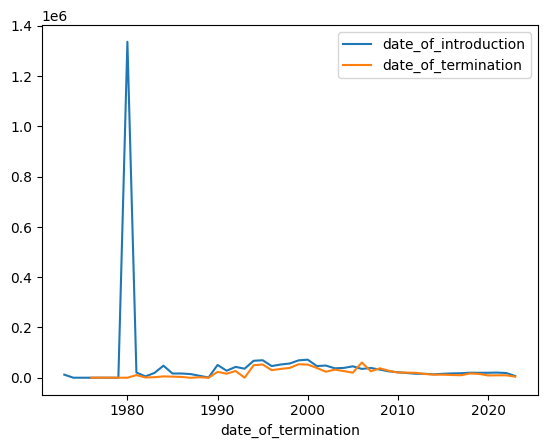

In [6]:
data = onspd_data_may_2023[onspd_data_may_2023.date_of_introduction.dt.year >= 1970]
data.groupby(data.date_of_introduction.dt.year).count()["date_of_introduction"].plot(legend=True)
data.groupby(data.date_of_termination.dt.year).count()["date_of_termination"].plot(legend=True)

<Axes: xlabel='date_of_termination'>

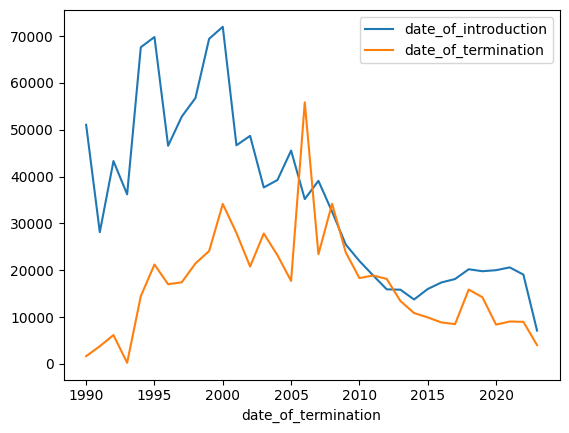

In [7]:
data = onspd_data_may_2023[onspd_data_may_2023.date_of_introduction.dt.year >= 1990]
data.groupby(data.date_of_introduction.dt.year).count()["date_of_introduction"].plot(legend=True)
data.groupby(data.date_of_termination.dt.year).count()["date_of_termination"].plot(legend=True)

## Create a Python file with active postcodes (set of strings)

This is the format used in the library.

In [8]:
active_postcodes = onspd_data_may_2023[onspd_data_may_2023["active"]]["postcode"].to_list()
print(f"There are {len(active_postcodes):,} active postcodes in May 2023")
set_str = str(set(active_postcodes))

filename = "postcodes_may_2023.py"
write_str = f"POSTCODE_MAY_2023 = {set_str}"

with open(filename, "w") as f:
    f.write(write_str)

There are 1,794,831 active postcodes in May 2023
